# Generate Music from Snake Robot Data
References for Sonification Process:
- https://jbrussell.github.io/eilive2020/part2a_sonification/
- https://medium.com/@astromattrusso/sonification-101-how-to-convert-data-into-music-with-python-71a6dd67751c

##Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pygame
import pandas as pd
import itertools as it
import librosa
import soundfile as sf
import scipy.signal as signal
from scipy.signal import find_peaks

from IPython.display import Audio

from pygame import mixer
pygame.init()

!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
!pip install midiutil
from midiutil import MIDIFile
from midi2audio import FluidSynth


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a l

## Load csv file of robot position and time data to Colab environment

In [ ]:
filename = input("Name of csv file without '.csv' (confirm loaded to Colab environment): ")  #name of csv data file

#Confirm that CSV file is loaded in Colab Environment
df = pd.read_csv(filename + '.csv')  #load data as a pandas dataframe

n_samples = len(df)
print(n_samples, 'data samples')

df.head() #take a look at first 5 rows

Name of csv file without '.csv' (confirm loaded to Colab environment): Serpentine_3
205 data samples


,vertical Position,time
0,0.000000,0.00
1,0.097797,0.05
2,0.193340,0.10
3,0.284440,0.15
4,0.369034,0.20


## Plot data

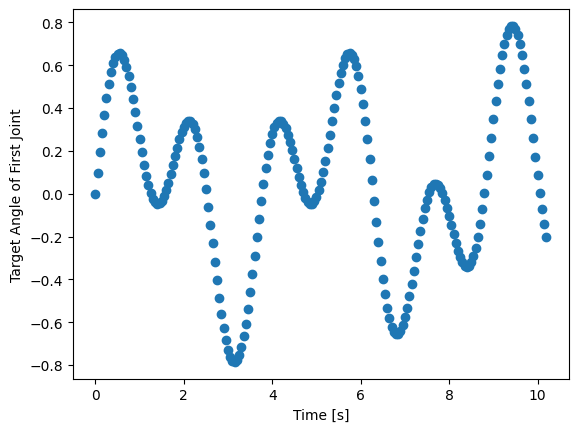

In [ ]:
time_data = df['time'].values

vpos = df['vertical Position'].values    #this is a numpy array (not a list)
plt.scatter(time_data, vpos)
plt.xlabel('Time [s]')
plt.ylabel('Target Angle of First Joint') #vPos is the angular value to apply to all the joints in the snake
plt.show()


## Prepare Sonification Mapping

### Generate Music

In [ ]:
class Generate_Music:
  def map_value(self, value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

  def str2midi(self, note_string):
    """Given a note string name (e.g. "Bb4"), returns its MIDI pitch number. (From audiolazy)
    """
    MIDI_A4 = 69
    data = note_string.strip().lower()
    name2delta = {"c": -9, "d": -7, "e": -5, "f": -4, "g": -2, "a": 0, "b": 2}
    accident2delta = {"b": -1, "#": 1, "x": 2}
    accidents = list(it.takewhile(lambda el: el in accident2delta, data[1:]))
    octave_delta = int(data[len(accidents) + 1:]) - 4
    return (MIDI_A4 + name2delta[data[0]] + sum(accident2delta[ac] for ac in accidents) + 12 * octave_delta)

  def midi_notes(self):
    #custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
    note_names = ['C1','C2','G2',
              'C3','E3','G3','A3','B3',
              'D4','E4','G4','A4','B4',
              'D5','E5','G5','A5','B5',
              'D6','E6','F#6','G6','A6']
    self.note_midis = [self.str2midi(n) for n in note_names] #make a list of midi note numbers
    self.n_notes = len(self.note_midis)
    print('Resolution:',self.n_notes, 'notes')
    return self.note_midis

  def create_notes(self):
    self.max_vpos = max(vpos) # will use for map function
    min_vpos = min(vpos) # will use for map function
    vpos_norm = self.map_value(vpos, min_vpos, self.max_vpos, 0, 1) #normalize data, so it runs from 0 to 1
    # Set min and max volume
    print(min_vpos, self.max_vpos)


    self.vol_min, self.vol_max = int((100-20*(math.exp(self.max_vpos)))),int((150+(20*math.exp(self.max_vpos)))) # Use math.exp to raise e to the power of max_vpos

    if (self.vol_max>120):
      self.vol_max = 120

    if (self.vol_min<40):
      self.vol_min = 40

    print(self.vol_min, self.vol_max)
    f_scale = 0.5  #lower than 1 to spread out more evenly
    #f_scale = self.max_vpos
    vpos_norm = vpos_norm**f_scale
    n_samples = len(vpos_norm)
    v_midi_data = []
    v_vel_data = []
    for i in range(n_samples):
      vnote_index = round(self.map_value(vpos_norm[i], 0, 1, 0, self.n_notes-1)) #max amp mapped to pitch, round the result so it becomes a list index
      v_midi_data.append(note_midis[int(vnote_index)])

    for i in range(n_samples):
      vnote_velocity = round(self.map_value(vpos_norm[i], 0, 1, self.vol_min, self.vol_max)) #higher velocity error will be louder
      v_vel_data.append(vnote_velocity)
    return v_midi_data, v_vel_data

  def create_sonification(self):
    bpm = 60 #default

    #create midi file object, add tempo
    my_midi_file = MIDIFile(1) #one track
    my_midi_file.addTempo(track=0, time=0, tempo=bpm)

    v_midi_data, v_vel_data = self.create_notes()

    for i in range(n_samples):
      my_midi_file.addNote(track=0, channel=0, pitch=v_midi_data[i], time=time_data[i], duration=2, volume=int(v_vel_data[i]))

    #create and save the midi file
    with open(filename + '.midi', "wb") as f:
      my_midi_file.writeFile(f)
      FluidSynth("font.sf2").midi_to_audio(filename + '.midi', filename + '.wav')

    print(f'Midi file created - download {filename}.midi from Colab environment to save (it may take a few seconds to appear).')


In [ ]:
gn = Generate_Music()
note_midis = gn.midi_notes()
gn.create_sonification()

Resolution: 23 notes
-0.78519693539828 0.78365116986602
56 120
Midi file created - download Serpentine_3.midi from Colab environment to save (it may take a few seconds to appear).


### Modify Existing Music

In [ ]:
from math import sin
from matplotlib import pylab
#from pylab import *


class Modify_Music():
  def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

  def find_peaks_data(self):
    self.pos_peaks = []
    self.time_peaks = []

    for x in range(1, len(vpos) - 1):
      #noise = 0.006 #works for baseline
      #noise = 0.003 #works for case 3
      noise = 0

      if ((vpos[x - 1]+noise) < vpos[x]) & ((vpos[x + 1]+noise) < vpos[x]):
        self.pos_peaks.append(vpos[x])
        self.time_peaks.append(time_data[x])

    plt.scatter(self.time_peaks, self.pos_peaks)
    plt.xlabel('Time [s]')
    plt.ylabel('Peaks of Target Angle Positions') #vPos is the angular value you will successively apply to all the joints in the snake
    plt.show()
    return self.time_peaks, self.pos_peaks


  def find_time_data(self):
    self.time_peaks, self.pos_peaks = self.find_peaks_data()
    time_diff = [x - self.time_peaks[i - 1] for i, x in enumerate(self.time_peaks)][1:]
    time_diff_peaks = min(time_diff)  # average time between peaks
    print(f'Time between peaks (t_peaks)): {time_diff_peaks}')
    self.mod_bpm = (60/time_diff_peaks) # beats per minute from data
    print(f'New bpm for music (60 bpm / t_peaks)): {self.mod_bpm}')

  def modify_tempo(self):
    # calculate tempo change
    self.orig_bpm = int(self.orig_bpm)
    tempo_change = self.mod_bpm/self.orig_bpm
    print("Tempo change: ", tempo_change)
    return tempo_change


  def modify_audio(self, input_file, output_file, tempo_change=1.0, pitch_shift=0, volume_change=1.0, sample_rate=22050):
    # Load the audio file
    audio, sr = librosa.load(input_file, sr=sample_rate)
    # Modify tempo
    audio_tempo_changed = librosa.effects.time_stretch(y=audio, rate=tempo_change)
    # Modify pitch
    audio_pitch_changed = librosa.effects.pitch_shift(y=audio_tempo_changed, sr=sr, n_steps=pitch_shift)
    # Modify volume
    audio_volume_changed = audio_pitch_changed * volume_change
    # Ensure the audio is in a valid range
    audio_volume_changed = np.clip(audio_volume_changed, -1.0, 1.0)
    # Save the modified audio to a new file
    sf.write(output_file, audio_volume_changed, sr)

    info = sf.info(output_file)
    clip_duration = info.duration

    if (clip_duration > time_data[-1]):
      data, sr= sf.read(output_file)
      start_time = 0
      end_time = time_data[-1]
      start_frame = int(start_time * sr)
      end_frame = int(end_time * sr)

      # Slice the audio data
      sliced_data = data[start_frame:end_frame]
      sf.write(output_file, sliced_data, sr)

  def create_sonification(self):
    # Modify Music
    input_file = input("Name of audio clip to modify ('Mozart' or 'Dvorak1' or 'Dvorak2': ") # Input mp3 file, tempo of about 173 bpm

    if input_file == 'Mozart':
      self.orig_bpm = 135
    elif input_file == 'Dvorak1':
      self.orig_bpm = 115
    elif input_file == 'Dvorak2':
      self.orig_bpm = 90
    else:
      print("Invalid input. Please enter 'Mozart', 'Dvorak1', or 'Dvorak2'.")
      return

    output_file = filename+ '_' + input_file + '.mp3'  # Output MP3 file
    input_file = input_file + '.mp3'

    pitch_shift = 0 #serpentine or unrecognized gait type (default)

    # calulate volume change based on max peak
    volume_change = max(self.pos_peaks)
    tempo_change = self.modify_tempo()

    self.modify_audio(input_file, output_file, tempo_change, pitch_shift, volume_change=volume_change)
    print("Audio file modified per robot simulation data. Download from Google Colab to save.")


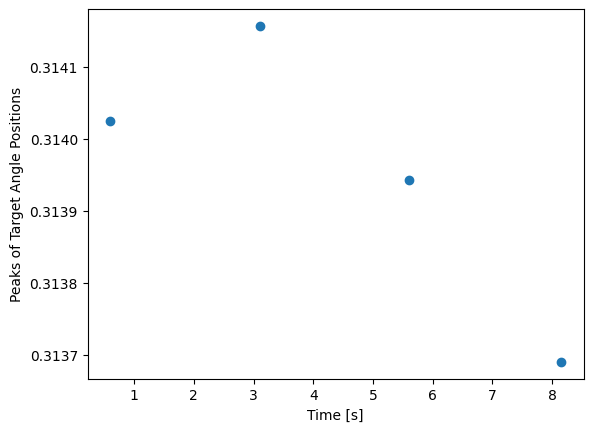

Time between peaks (t_peaks)): 2.4999999999999996
New bpm for music (60 bpm / t_peaks)): 24.000000000000004


In [ ]:
mod = Modify_Music()
mod.find_time_data()

In [ ]:
mod.create_sonification()

Name of audio clip to modify ('Mozart' or 'Dvorak1' or 'Dvorak2': Mozart
Tempo change:  0.1777777777777778
Audio file modified per robot simulation data. Download from Google Colab to save.
